# Hodgkin-Huxley IK Model

This example shows how the Hodgkin-Huxley potassium current (IK) toy model can be used.

This model recreates an experiment where a sequence of voltages is applied to a [giant axon from a squid](https://en.wikipedia.org/wiki/Squid_giant_axon), and the resulting potassium current is measured. For information on the science behind it, see the [original 1952 paper](https://doi.org/10.1113/jphysiol.1952.sp004764).


In [1]:
import pints
import pints.toy
import matplotlib.pyplot as plt
import numpy as np

model = pints.toy.HodgkinHuxleyIKModel()

We can get an example set of parameters using the `suggested_parameters()` method:

In [2]:
x_true = np.array(model.suggested_parameters())
x_true

array([1.00e-02, 1.00e+01, 1.00e+01, 1.25e-01, 8.00e+01])

The voltage protocol used in the model has a fixed duration, which we can see using `suggested_duration()`:

In [3]:
model.suggested_duration()

1200

And it can also provide a suggested sequence of sampling times:

In [4]:
times = model.suggested_times()

Using the suggested parameters and times, we can run a simulation:

In [5]:
values = model.simulate(x_true, times)

This gives us all we need to create a plot of current versus time:

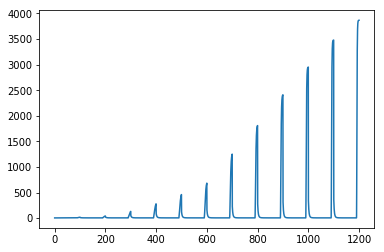

In [6]:
plt.figure()
plt.plot(times, values)
plt.show()

The voltage protocol used to generate this data consists of 12 segments, of 100ms each.
Each segment starts with 90ms at the _holding potential_, followed by a 10ms step to an increasing _step potential_.
During this step, a current is elicited, while the signal at the holding potential is almost zero.

A common way to represent this data is to show only the data during the step, and to _fold_ the steps over each other. This can be done using the `fold()` method:

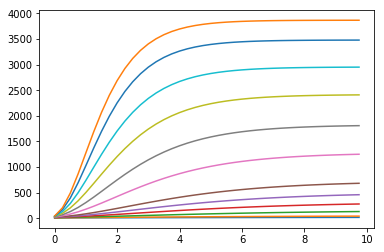

In [7]:
plt.figure()
for t, v in model.fold(times, values):
    plt.plot(t, v)
plt.show()

This recreates Figure 3 in the original paper. 

Now we will add some noise to generate some fake "experimental" data and try to recover the original parameters.

In [10]:
# Add noise
values += np.random.normal(0, 40, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Select some boundaries above and below the true values
lower = [x / 1.5 for x in x_true]
upper = [x * 1.5 for x in x_true]
boundaries = pints.RectangularBoundaries(lower, upper)

# Perform an optimization with boundaries and hints
x0 = x_true * 0.98
optimiser = pints.Optimisation(score, x0, boundaries=boundaries, method=pints.CMAES)
optimiser.set_max_unchanged_iterations(100)
optimiser.set_log_to_screen(True)
found_parameters, found_score = optimiser.run()

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(x0[k]))

Minimising error measure
using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      7969260    0:00.1
1     16     7963398    0:00.1
2     24     7963398    0:00.1
3     32     7951184    0:00.1
20    168    7931803    0:00.5
40    328    7930191    0:01.0
60    488    7930191    0:01.5
80    648    7925721    0:02.0
100   808    7912739    0:02.5
120   968    7912680    0:03.0
140   1128   7912356    0:03.6
160   1288   7911403    0:04.0
180   1448   7911383    0:04.5
200   1608   7911371    0:05.0
220   1768   7911370    0:05.4
240   1928   7911370    0:05.9
260   2088   7911370    0:06.5
280   2248   7911370    0:06.9
300   2408   7911370    0:07.4
320   2568   7911370    0:08.0
340   2728   7911370    0:08.5
360   2888   7911370    0:08.9
380   3048   7911370    0:09.5
400   3208   7911370    0:10.0
420   3368   7911370    0:10.5
WARNING (module=cma.utilities.utils, iteration=422):  flat 

We can then compare the true and fitted model output

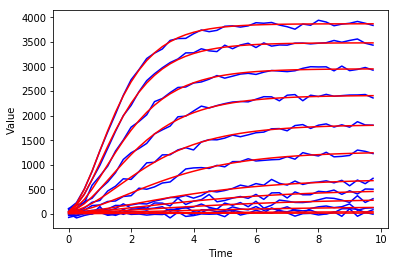

In [11]:
# Evaluate model at found parameters
found_values = problem.evaluate(found_parameters)

# Show quality of fit
plt.figure()
plt.xlabel('Time')
plt.ylabel('Value')
for t, v in model.fold(times, values):
    plt.plot(t, v, c='b', label='Noisy data')
for t, v in model.fold(times, found_values):
    plt.plot(t, v, c='r', label='Fit')
plt.show()